# Creation of a Staged Tree

## EventTree Class

The first starting point in constructing a Chain Event Graph (CEG) is to create 
an *event tree* describing the process being studies. An event tree is a directed 
tree graph with a single root node. The nodes with no emanating edges are
called *leaves*, and the non-leaf nodes are called *situations*. 

To create an event tree from a tabular data set in cegpy we
first need to import the data set and then initialise the 
`EventTree` object which can be done with the following code.

In [7]:
from cegpy import EventTree
import pandas as pd

df = pd.read_excel('../../data/medical_dm_modified.xlsx')
et = EventTree(df)

In order to display the EventTree, we can use the method `create_figure()`. The numbers above the edges of the event tree represent the number of indiviuals who passed through the given edge. 

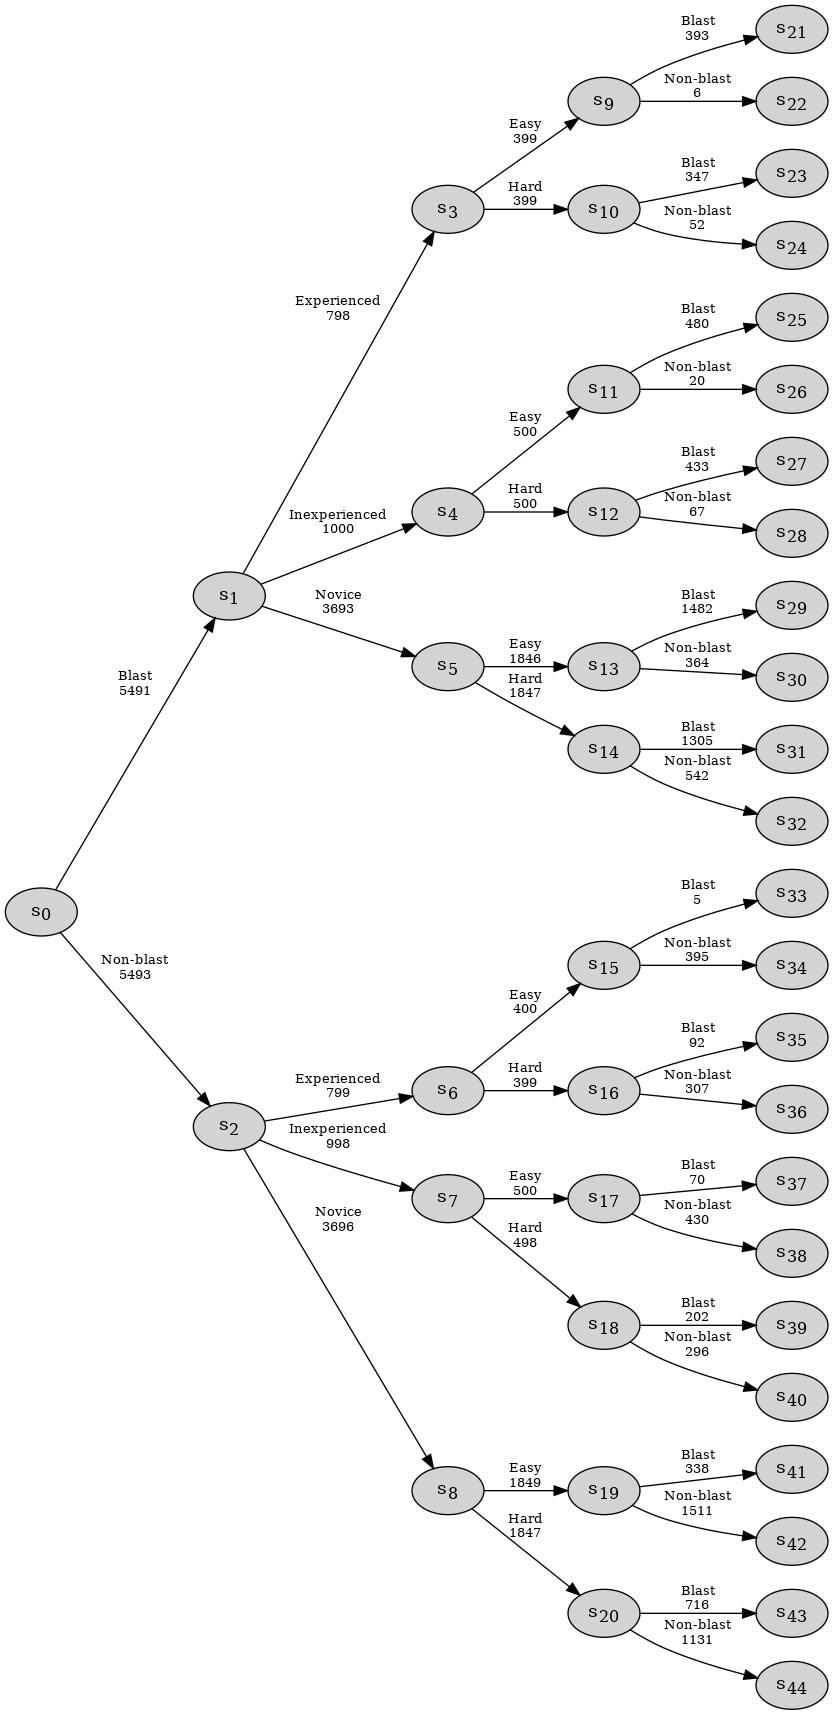

In [8]:
et.create_figure()

## StagedTree Class

In an event tree, each situation is associated with a transition parameter vector which indicates the conditional
probability of an individual, who has arrived at the situation, going along one of its edges. In order to create a CEG, we first need to elict a *staged tree*. 
This is done by first need to partition situations into *stages*, which are collection of situation in the event tree whose immediate evolutions, i.e. their
associated conditional transition parameter vectors, are equivalent. To indicate this symmetry, all situations in the same stage are assinged a single colour.

Identification of the stages in the event tree can be done using any suitable model selection algorithm. Currently, the only avaible selection algoirhtm in `cegpy` is the *agglomerative hierarchical clustering (AHC)* algorithm (Freeman and Smith, 2011).

In order to creat a staged tree in `cegpy` we first initialize a `StagedTree` object from the dataset and then run th AHC algorithm using the `create_AHC_tarnsitions` method, as displayed below. The output of the AHC algorithm is a dictionary containing the following information:
- `Merged Situations` - a list of tuples representing the partition of the nodes into stages
- `Log Likelihood` - the log likelihood of the data under the model selected by AHC

In [9]:
from cegpy import StagedTree

st = StagedTree(df)
st.calculate_AHC_transitions()

{'Merged Situations': [('s1', 's2'),
  ('s18', 's20'),
  ('s10', 's12'),
  ('s4', 's3', 's7', 's5', 's8', 's6'),
  ('s11', 's9'),
  ('s17', 's16', 's19'),
  ('s0',),
  ('s13',),
  ('s14',),
  ('s15',)],
 'Log Likelihood': -30091.353114865367}

Within `cegpy`, singleton stages, i.e. stages contatining a single situation, are coloured white, leaves and their corresponding sink node are coloured in light-grey. Runing AHC on our data set results in the following staged tree.

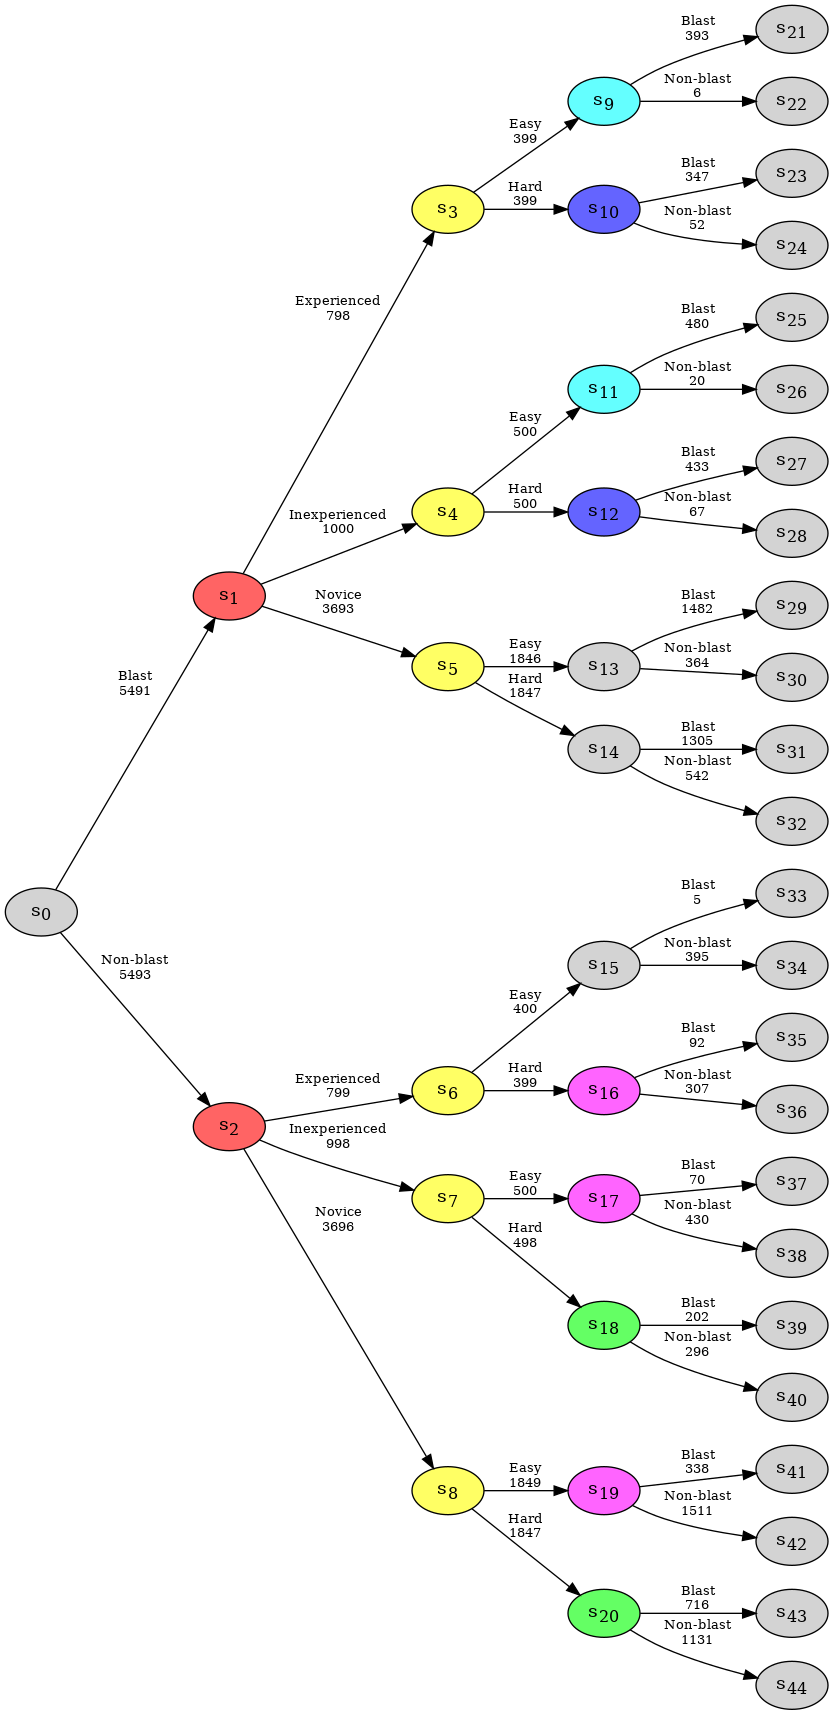

In [10]:
st.create_figure()

### Structural Zeros

### Custom Hyperstages

### Modifiying the Graph of a StagedTree

By default, the colours of the nodes in `cegpy` are selected uniformly at random from the entire spectrum of colours. If we want to use a specific colour palette, a list of colours to be used by the AHC algorithm can be specified as a parameter when calling the `create_AHC_tarnsitions` method, for example:

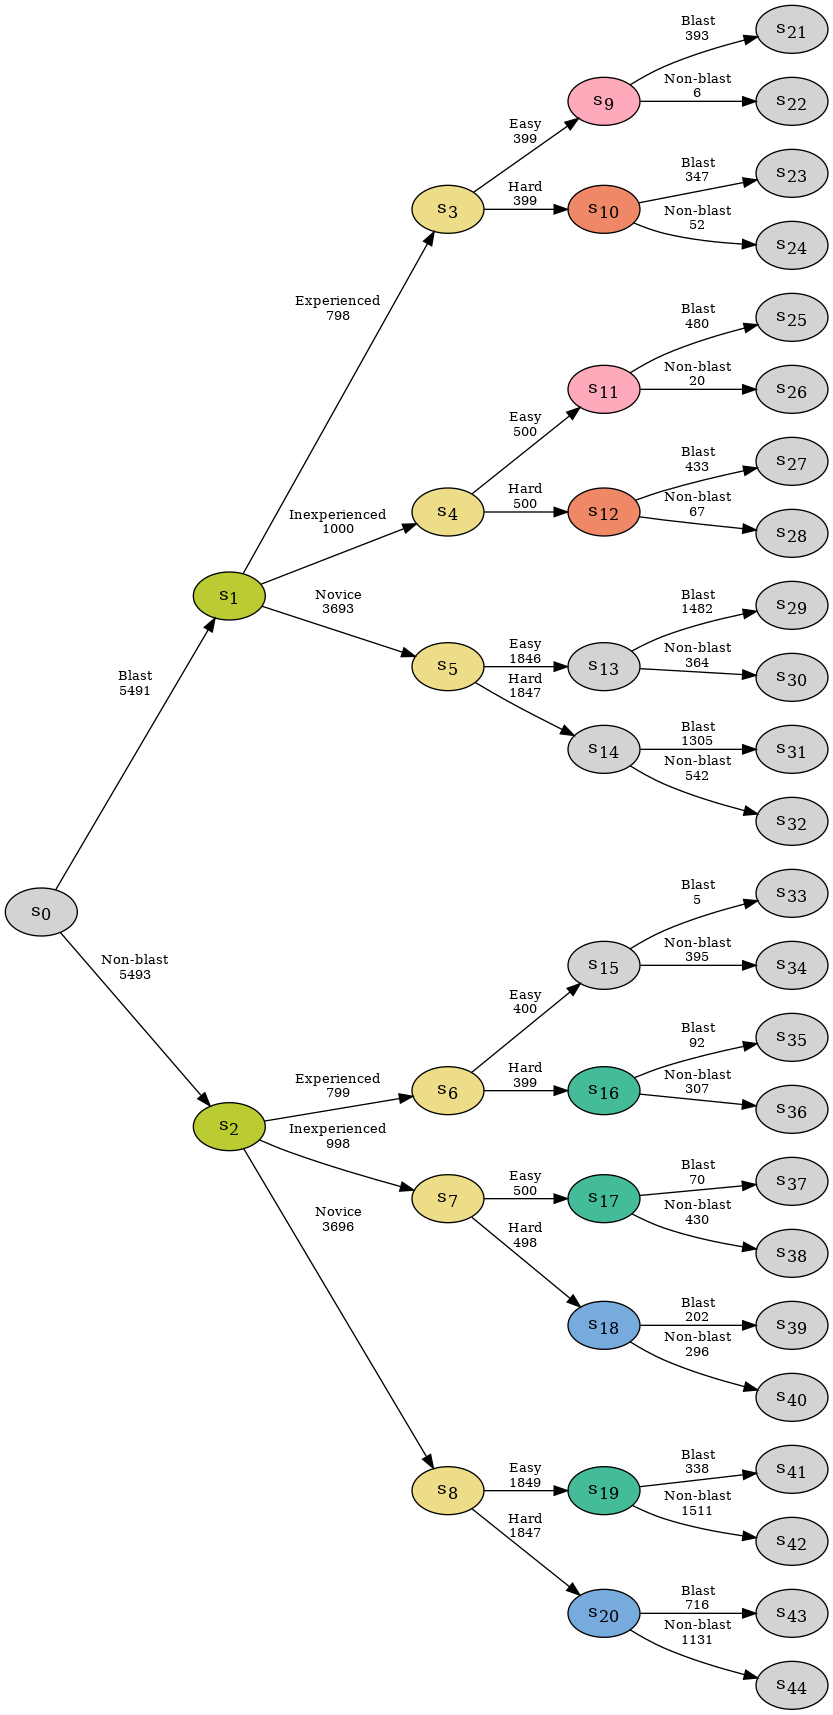

In [11]:
colours = ['#BBCC33','#77AADD','#EE8866','#EEDD88','#FFAABB','#44BB99']
st.calculate_AHC_transitions(colour_list=colours)
st.create_figure()

`cepgy` is built on [NetworkX](https://networkx.org) adn [PyDotPlus](https://pydotplus.readthedocs.io), we can access the underlying `pydotplus.grphiviz.Dot` object by accesing the  `dot_graph` property. This enables visual modifications of our staged tree or CEG. For example, the following code modifies the distance between the nodes and changes the style of an edge from solid to dashed.

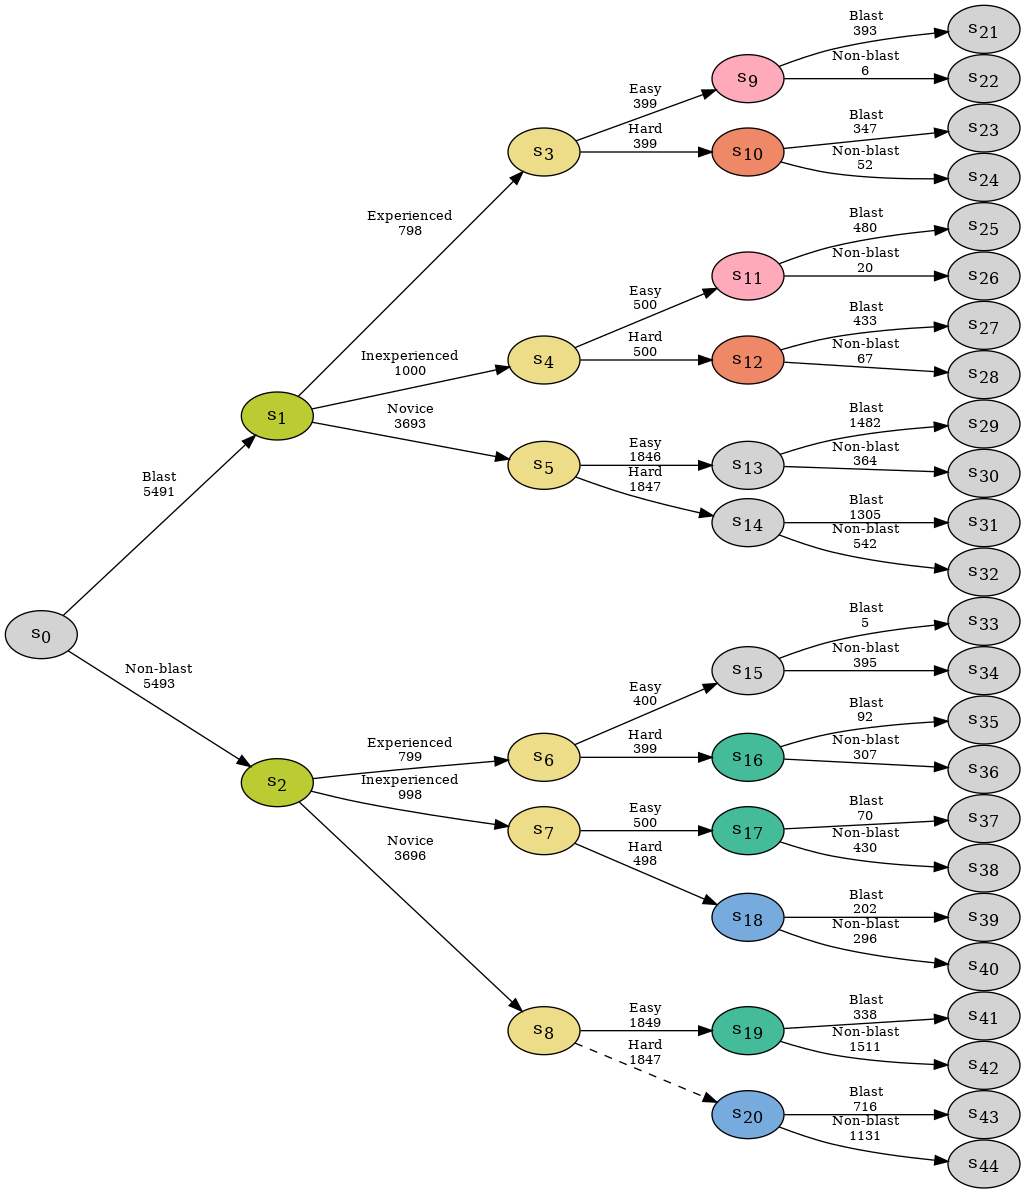

In [12]:
from IPython.display import Image
g = st.dot_staged_graph()
g.set('ranksep', 1)
g.set('nodesep', 0.005)
g.get_edge(('s8', 's20'))[-1].set_style('dashed')
Image(g.create_png())